# A Convolutional Neural Network ensemble model for Pneumonia Detection using chest X-ray images (Phase 2)

This phase included the contribution to the research paper and rewriting of the research paper with our contribution.

#### Implemented by:
- Sahal Saeed
- Fardeen Farhat
- Zain Ul Wahab

## Standard Library Imports

```python
import os
import pickle
```
- `os`: Provides functions for interacting with the operating system, such as file path manipulations and environment variable access.
- `pickle`: Used for serializing and deserializing Python objects (e.g., saving/loading trained models or preprocessing configurations).

---

## Numerical & Data Handling Libraries

```python
import numpy as np
from collections import Counter
```
- `numpy`: Fundamental package for numerical computations and array handling.
- `Counter`: A collection class from the `collections` module to count occurrences of elements (e.g., label distributions).

---

## Visualization Libraries

```python
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
```
- `seaborn`: Provides high-level interface for drawing attractive statistical graphics.
- `matplotlib.pyplot`: Core plotting library to create static, interactive, and animated visualizations.
- `matplotlib.cm`: Module for handling colormaps, useful in visualizing class activation maps or gradients.

---

## TensorFlow & Keras Core Modules

```python
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models as md
from tensorflow.keras import Input
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
```
- `tensorflow`: The main deep learning framework.
- `layers`: Contains layer classes (Conv2D, Dense, etc.).
- `models`: Used to construct and manage models (`Sequential`, `Model`); aliased as `md` for brevity.
- `Input`: Specifies the input layer of a functional model.
- `regularizers`: Used to apply L1, L2, or other regularization to layers to prevent overfitting.
- `metrics`: Contains built-in evaluation metrics (e.g., accuracy, AUC).
- `backend (K)`: Keras backend functions, like custom metric definitions or gradient manipulations.

---

## Evaluation Metrics

```python
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
```
- `f1_score`, `precision_score`, `recall_score`, `accuracy_score`: Used to evaluate model performance.
- `confusion_matrix`: Returns the confusion matrix to evaluate classification results.
- `classification_report`: Generates a text summary of precision, recall, F1-score, and support for each class.

---

## Pre-trained Model & Image Preprocessing

```python
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
```
- `ResNet50`: A pre-trained deep convolutional neural network architecture available in Keras.
- `ImageDataGenerator`: Used to load and augment image data for training/validation.

---

In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models as md
from tensorflow.keras import Input
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
from tensorflow.keras import metrics
from sklearn.metrics import recall_score
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-11 19:28:58.686862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746991738.710477    2031 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746991738.717831    2031 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Dataset & Analyze Class Distribution

In this section, we load the Chest X-ray dataset and analyze the distribution of images across the different categories (NORMAL and PNEUMONIA) for each dataset split (train, test, and validation). 

- **data_dir**: Specifies the path to the dataset.
- **splits**: A list of the dataset splits, i.e., 'train', 'test', and 'val'.
- **categories**: A list of the two categories: 'NORMAL' and 'PNEUMONIA'.
- The code loops through each split and category to count the number of images in each class and stores the results in a dictionary `data_distribution`.

In [2]:
# Dataset path
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [3]:
# Count images in each category for train, test, val
splits = ['train', 'test', 'val']
categories = ['NORMAL', 'PNEUMONIA']
data_distribution = {}

for split in splits:
    data_distribution[split] = {}
    for category in categories:
        folder_path = os.path.join(data_dir, split, category)
        count = len(os.listdir(folder_path))
        data_distribution[split][category] = count

In [4]:
BATCH_SIZE = 32
IMG_SIZE = 180
def prepare_dataset(directory, augment=False, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=shuffle
    )

    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomTranslation(0.1, 0.1)
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    normalization_layer = tf.keras.layers.Rescaling(1./256)
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# Prepare datasets
train_ds = prepare_dataset(os.path.join(data_dir, 'train'), augment=True)
val_ds = prepare_dataset(os.path.join(data_dir, 'val'), shuffle=False)
test_ds = prepare_dataset(os.path.join(data_dir, 'test'), shuffle=False)

Found 5216 files belonging to 2 classes.


I0000 00:00:1746991747.391230    2031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746991747.391928    2031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## CNN with Attention Mechanism (Parameterized by Kernel Size)

This function defines a Convolutional Neural Network (CNN) enhanced with an attention mechanism, allowing the model to focus on the most relevant spatial features in the image. It is parameterized by kernel size and input shape for flexibility and experimentation.

- **kernel_size**: Determines the dimensions of the convolutional filters. Default is (3, 3).
- **input_shape**: Specifies the shape of the input images, defaulting to (180, 180, 1) for grayscale X-ray images.
- The model contains three convolutional layers with batch normalization and max-pooling, progressively extracting spatial features.
- An **attention mechanism** is applied after the third convolutional block:
  - A 1x1 convolution with sigmoid activation generates an attention map.
  - This map is element-wise multiplied with the feature map to enhance important regions.
- Both the original and attention-weighted features are globally averaged and concatenated to retain complementary information.
- The combined features are passed through a dense layer with dropout for regularization.
- The final output layer uses a sigmoid activation, making it suitable for binary classification.
- The model is compiled with the Adam optimizer, binary cross-entropy loss, and evaluates accuracy, precision, and recall.


In [6]:
def build_cnn_attention_model(kernel_size=(3, 3), input_shape=(180, 180, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Convolutional Layer 1
    x = layers.Conv2D(32, kernel_size, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional Layer 2
    x = layers.Conv2D(64, kernel_size, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Convolutional Layer 3
    x = layers.Conv2D(128, kernel_size, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    conv3_output = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Attention mechanism
    attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv3_output)
    attention_features = layers.Multiply()([conv3_output, attention])
    
    # Global spatial information combined with attention-weighted features
    pooled_features = layers.GlobalAveragePooling2D()(conv3_output)
    attended_features = layers.GlobalAveragePooling2D()(attention_features)
    combined_features = layers.Concatenate()([pooled_features, attended_features])
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)  # Keep dropout to prevent overfitting
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = md.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', metrics.Precision(), metrics.Recall()]
    )
    
    return model

### Model Storage & Configuration Setup

Initializes dictionaries to store multiple models, their training histories, thresholds for classification, and performance metrics. Also defines a set of kernel sizes for each model variation, enabling experiments with different convolutional receptive fields (3x3, 5x5, 7x7). This setup facilitates organized training and comparison of multiple CNN architectures.


In [ ]:
# Dictionary to store our models
models = {}
model_histories = {}
model_thresholds = {}
model_metrics = {}

# Define kernel sizes for each model
kernel_sizes = {
    'model_3x3': (3, 3),
    'model_5x5': (5, 5),
    'model_7x7': (7, 7)
}

## Model Training Function with Attention and Threshold Optimization

This function trains a CNN model with a specific kernel size and evaluates its performance.

- Takes in a kernel name, kernel size, and number of epochs (default: 10).
- Builds and trains the attention-based CNN model using the given kernel size.
- Stores the trained model and its training history in dictionaries.
- Predicts probabilities on the validation set and determines the best classification threshold using F1 score.
- Uses the optimal threshold to evaluate the model on both validation and test sets.
- Calculates and stores key metrics: F1 score, accuracy, precision, and recall for both sets.
- Saves the trained model to disk in the Kaggle working directory.
- Prints evaluation results and a classification report for the test set.


In [ ]:
# Function to train a model with specific kernel size
def train_model(kernel_name, kernel_size, epochs=10):
    print(f"\n=== Training model with {kernel_name} kernel ===")
    model = build_cnn_attention_model(kernel_size=kernel_size)
    
    # Train the model
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
    # Store model and history
    models[kernel_name] = model
    model_histories[kernel_name] = history
    
    # Find optimal threshold
    val_probas = model.predict(val_ds, verbose=0)
    val_true = np.concatenate([y for x, y in val_ds], axis=0)
    
    # Calculate F1 scores for different thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    f1_scores = []
    
    for threshold in thresholds:
        val_pred = (val_probas > threshold).astype(int)
        f1_scores.append(f1_score(val_true, val_pred))
    
    # Find the threshold that gives the best F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    model_thresholds[kernel_name] = optimal_threshold
    print(f"🔍 Optimal threshold for {kernel_name}: {optimal_threshold:.4f}")
    
    # Evaluate with optimal threshold
    val_pred = (val_probas > optimal_threshold).astype(int)
    test_probas = model.predict(test_ds, verbose=0)
    test_true = np.concatenate([y for x, y in test_ds], axis=0)
    test_pred = (test_probas > optimal_threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        'val_f1': f1_score(val_true, val_pred),
        'test_f1': f1_score(test_true, test_pred),
        'val_accuracy': accuracy_score(val_true, val_pred),
        'test_accuracy': accuracy_score(test_true, test_pred),
        'val_precision': precision_score(val_true, val_pred),
        'test_precision': precision_score(test_true, test_pred),
        'val_recall': recall_score(val_true, val_pred),
        'test_recall': recall_score(test_true, test_pred)
    }
    
    model_metrics[kernel_name] = metrics
    
    # Print key metrics
    print(f"📊 F1 Score (Validation): {metrics['val_f1']:.4f}")
    print(f"📊 F1 Score (Test): {metrics['test_f1']:.4f}")
    
    # Save model
    save_dir = '/kaggle/working/'
    model_path = os.path.join(save_dir, f"cnn_attention_{kernel_name}.h5")
    model.save(model_path)
    print(f"✅ Model saved at: {model_path}")
    
    # Classification report
    print(f"\n📋 Classification Report for {kernel_name} (Test Set):")
    print(classification_report(test_true, test_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    return metrics

## Weighted Ensemble Prediction Function

This function generates predictions using a weighted ensemble of all trained models.

- Accepts a dataset, a dictionary of model weights, and a classification threshold (default: 0.5).
- Extracts the ground truth labels from the dataset.
- For each model, computes predictions and multiplies them by their assigned weight.
- Sums the weighted predictions across models to create an ensemble output.
- Applies the threshold to produce final binary predictions.
- Returns the true labels and the ensemble predictions.


In [ ]:
# Function to predict with weighted ensemble
def get_weighted_preds_and_labels(ds, weights, threshold=0.5):
    y_true = np.concatenate([y for _, y in ds], axis=0)

    weighted_sum = 0
    for key, model in models.items():
        preds = model.predict(ds, verbose=0)
        weighted_sum += weights[key] * preds

    y_pred = (weighted_sum > threshold).astype(int)
    return y_true, y_pred

## Optimal Ensemble Threshold Finder

This function identifies the best threshold for making predictions with a weighted ensemble of models.

- Takes in a dictionary of model weights.
- Computes the weighted sum of predictions from all models on the validation set.
- Evaluates F1 scores for different threshold values (from 0.1 to 1.0).
- Finds and returns the threshold that maximizes the F1 score on the validation set.


In [ ]:
# Function to find optimal ensemble threshold
def find_optimal_ensemble_threshold(weights):
    val_true = np.concatenate([y for _, y in val_ds], axis=0)
    
    # Calculate weighted predictions
    weighted_sum = 0
    for key, model in models.items():
        preds = model.predict(val_ds, verbose=0)
        weighted_sum += weights[key] * preds
    
    # Calculate F1 scores for different thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    f1_scores = []
    
    for threshold in thresholds:
        val_pred = (weighted_sum > threshold).astype(int)
        f1_scores.append(f1_score(val_true, val_pred))
    
    # Find the threshold that gives the best F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

## Ensemble Model Evaluation Function

This function evaluates the performance of a weighted ensemble model on both validation and test sets.

- Accepts model weights and the optimal threshold.
- Computes weighted predictions for the validation and test sets.
- Calculates F1 scores, accuracy, precision, and recall for both sets.
- Prints key evaluation metrics for the ensemble model.
- Displays a classification report for the test set.
- Returns a dictionary with the computed metrics (F1, accuracy, precision, recall).


In [ ]:
# Function to evaluate ensemble model
def evaluate_ensemble(weights, threshold):
    # Validation set
    val_true, val_pred = get_weighted_preds_and_labels(val_ds, weights, threshold)
    val_f1 = f1_score(val_true, val_pred)
    
    # Test set
    test_true, test_pred = get_weighted_preds_and_labels(test_ds, weights, threshold)
    test_f1 = f1_score(test_true, test_pred)
    
    # Calculate metrics
    metrics = {
        'val_f1': val_f1,
        'test_f1': test_f1,
        'val_accuracy': accuracy_score(val_true, val_pred),
        'test_accuracy': accuracy_score(test_true, test_pred),
        'val_precision': precision_score(val_true, val_pred),
        'test_precision': precision_score(test_true, test_pred),
        'val_recall': recall_score(val_true, val_pred),
        'test_recall': recall_score(test_true, test_pred)
    }
    
    print("\n=== Ensemble Model Evaluation ===")
    print(f"F1 Score (Validation): {val_f1:.4f}")
    print(f"F1 Score (Test): {test_f1:.4f}")
    print(f"Accuracy (Test): {metrics['test_accuracy']:.4f}")
    print(f"Precision (Test): {metrics['test_precision']:.4f}")
    print(f"Recall (Test): {metrics['test_recall']:.4f}")
    
    print("\n Classification Report for Ensemble Model (Test Set):")
    print(classification_report(test_true, test_pred, target_names=['NORMAL', 'PNEUMONIA']))
    
    return metrics

## Plot Training History for All Models

This function generates and saves plots of training and validation metrics for all models.

- Defines the key metrics to be plotted: accuracy, loss, precision, and recall.
- Creates separate plots for each metric (training and validation).
- Loops through the `model_histories` dictionary to extract and plot the relevant metrics for each model.
- Saves the plots as images (`training_<metric>.png` and `validation_<metric>.png`) in the working directory.
- Displays the plots to provide a visual representation of model performance over epochs.


In [ ]:
# Function to plot training history for all models with separate plots
def plot_training_history():
    metrics_to_plot = {
        'accuracy': 'Accuracy',
        'loss': 'Loss',
        'precision': 'Precision',
        'recall': 'Recall'
    }
    
    # Create a separate plot for each metric (train and validation separated)
    for metric_key, metric_name in metrics_to_plot.items():
        # Training plot
        plt.figure(figsize=(12, 6))
        for model_name, history in model_histories.items():
            if metric_key in history.history:  # Check if metric exists in history
                plt.plot(history.history[metric_key], label=f'{model_name}')
        
        plt.title(f'Training {metric_name}')
        plt.ylabel(metric_name)
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/training_{metric_key}.png')
        plt.show()
        
        # Validation plot
        plt.figure(figsize=(12, 6))
        for model_name, history in model_histories.items():
            val_metric_key = f'val_{metric_key}'
            if val_metric_key in history.history:  # Check if validation metric exists
                plt.plot(history.history[val_metric_key], label=f'{model_name}')
        
        plt.title(f'Validation {metric_name}')
        plt.ylabel(metric_name)
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/validation_{metric_key}.png')
        plt.show()

## Plot Comparative Metrics for All Models (Including Ensemble)

This function generates a comparative bar plot of performance metrics for all models, including the ensemble model.

- Combines the metrics from individual models and the ensemble model.
- Compares key metrics: accuracy, precision, recall, and F1 score on the test set.
- Creates a grouped bar plot with each model's performance for each metric.
- Adds values on top of the bars to display the exact scores.
- Saves the plot as `model_comparison.png` and displays it for visual comparison.


In [ ]:
# Plot comparative metrics for all models including ensemble
def plot_comparative_metrics(ensemble_metrics):
    # Combine metrics from all models
    all_metrics = {**model_metrics, 'ensemble': ensemble_metrics}
    
    # Metrics to compare
    metric_names = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    pretty_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set width of bar
    barWidth = 0.15
    
    # Set position of bar on X axis
    positions = np.arange(len(metric_names))
    
    # Make the plot
    i = 0
    for model_name, metrics in all_metrics.items():
        values = [metrics[m] for m in metric_names]
        ax.bar(positions + i*barWidth, values, width=barWidth, label=model_name)
        i += 1
    
    # Add labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Model Performance')
    ax.set_xticks(positions + barWidth * (len(all_metrics)-1)/2)
    ax.set_xticklabels(pretty_names)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for i, model_name in enumerate(all_metrics.keys()):
        for j, metric in enumerate(metric_names):
            value = all_metrics[model_name][metric]
            ax.text(positions[j] + i*barWidth, value + 0.01, f'{value:.3f}', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/model_comparison.png')
    plt.show()

## Save Results to File

This function saves the results of the individual models and the ensemble model to a text file for later reference.

- **Individual Model Thresholds**: Saves the threshold values for each model.
- **Individual Model Metrics**: Records the test set metrics (F1 score, accuracy, precision, recall) for each individual model.
- **Ensemble Model Configuration**: Records the ensemble model's threshold and weights.
- **Ensemble Model Metrics**: Saves the test set metrics for the ensemble model.
- The results are saved in the file `model_results.txt` within the working directory.


In [ ]:
# Save metrics and thresholds to file
def save_results(ensemble_threshold, ensemble_weights, ensemble_metrics):
    with open('/kaggle/working/model_results.txt', 'w') as f:
        f.write("=== CNN Ensemble with Attention for Pneumonia Detection ===\n\n")
        
        f.write("Individual Model Thresholds:\n")
        for model_name, threshold in model_thresholds.items():
            f.write(f"{model_name}: {threshold:.4f}\n")
        
        f.write("\nIndividual Model Metrics (Test Set):\n")
        for model_name, metrics in model_metrics.items():
            f.write(f"\n{model_name}:\n")
            f.write(f"  F1 Score: {metrics['test_f1']:.4f}\n")
            f.write(f"  Accuracy: {metrics['test_accuracy']:.4f}\n")
            f.write(f"  Precision: {metrics['test_precision']:.4f}\n")
            f.write(f"  Recall: {metrics['test_recall']:.4f}\n")
        
        f.write("\nEnsemble Model Configuration:\n")
        f.write(f"Threshold: {ensemble_threshold:.4f}\n")
        f.write("Weights:\n")
        for model_name, weight in ensemble_weights.items():
            f.write(f"  {model_name}: {weight:.2f}\n")
        
        f.write("\nEnsemble Model Metrics (Test Set):\n")
        f.write(f"F1 Score: {ensemble_metrics['test_f1']:.4f}\n")
        f.write(f"Accuracy: {ensemble_metrics['test_accuracy']:.4f}\n")
        f.write(f"Precision: {ensemble_metrics['test_precision']:.4f}\n")
        f.write(f"Recall: {ensemble_metrics['test_recall']:.4f}\n")


=== Training model with model_3x3 kernel ===
Epoch 1/10


I0000 00:00:1746991755.245895    2088 service.cc:148] XLA service 0x7b614c011d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746991755.245941    2088 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746991755.245946    2088 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746991755.975702    2088 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7101 - loss: 0.6397 - precision: 0.7871 - recall: 0.8747  

I0000 00:00:1746991760.708549    2088 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.8242 - loss: 0.3742 - precision: 0.8707 - recall: 0.8978 - val_accuracy: 0.5000 - val_loss: 0.9191 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8830 - loss: 0.2689 - precision: 0.9204 - recall: 0.9226 - val_accuracy: 0.5000 - val_loss: 1.5848 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8936 - loss: 0.2536 - precision: 0.9300 - recall: 0.9267 - val_accuracy: 0.5000 - val_loss: 3.2812 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9179 - loss: 0.1992 - precision: 0.9441 - recall: 0.9454 - val_accuracy: 0.6875 - val_loss: 0.6826 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9251 - loss: 0.1844 - precision: 0.9490 - recall: 0.9504 - val_accuracy: 0.5000 - val_loss: 1.6595

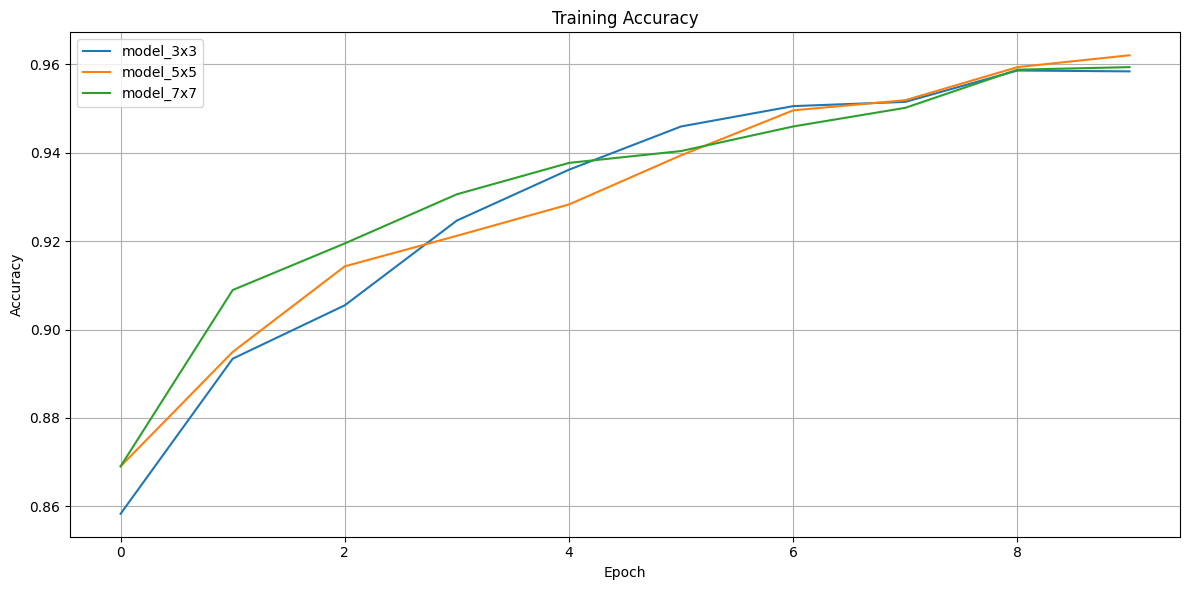

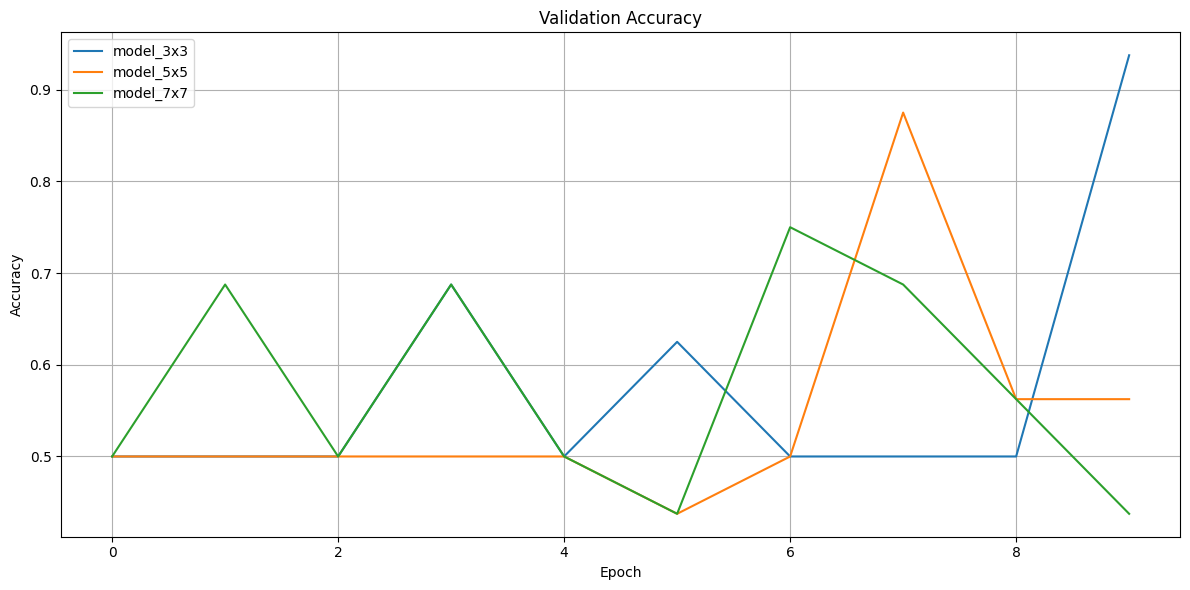

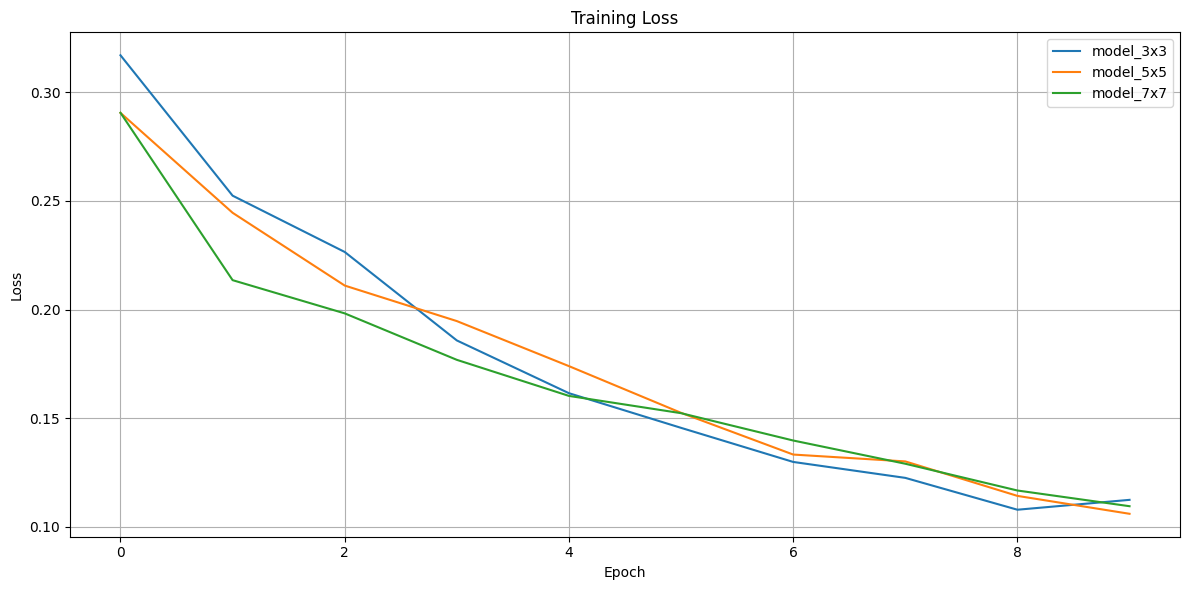

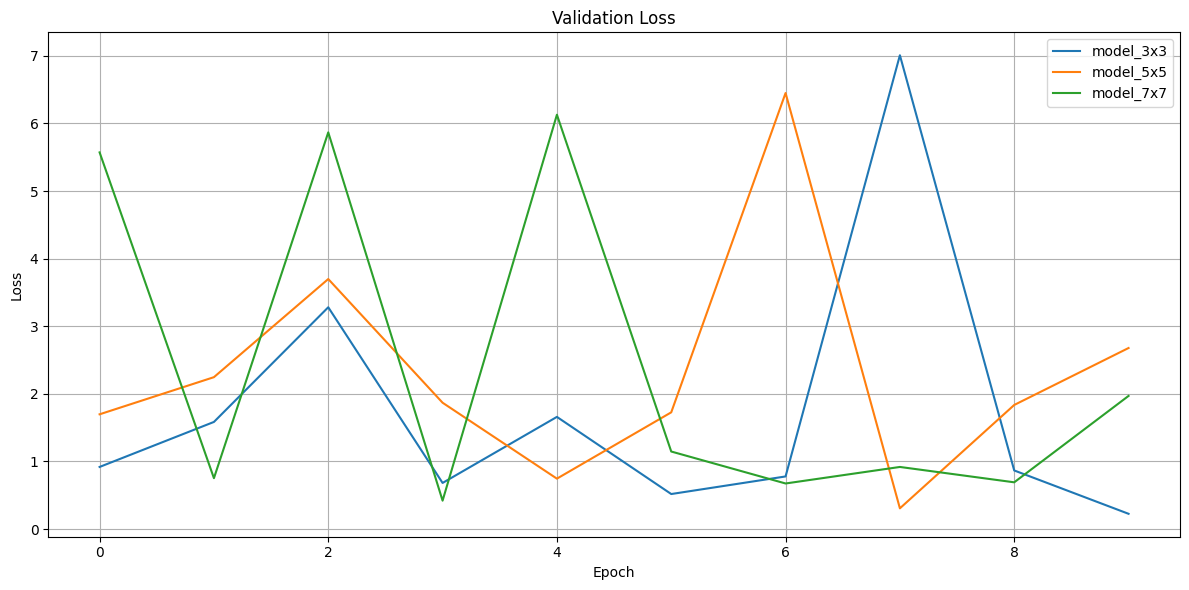

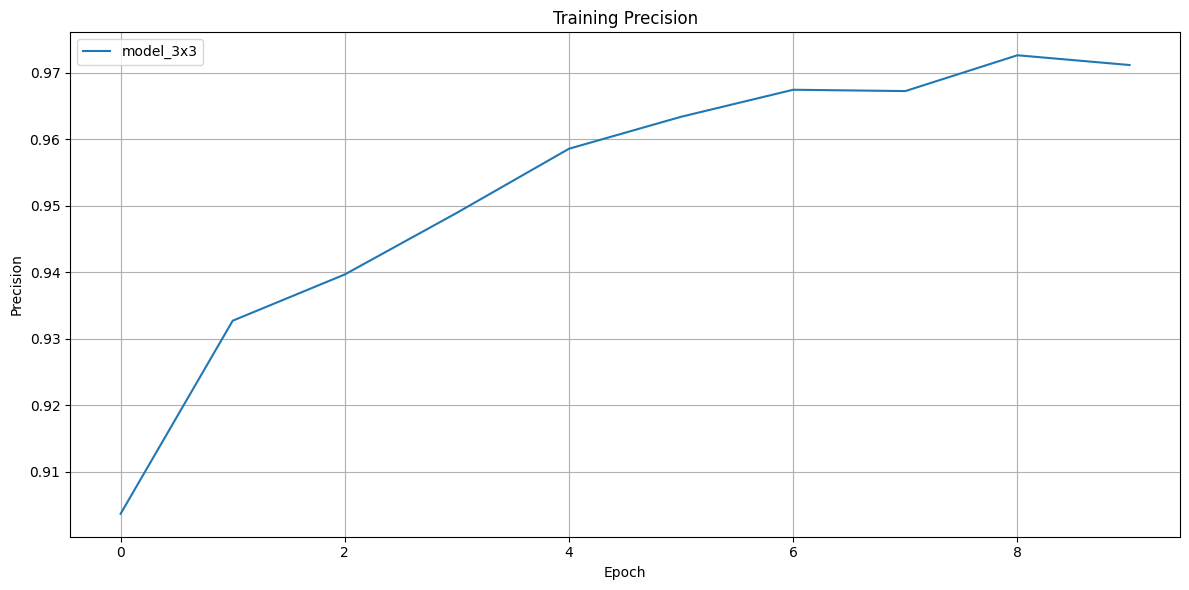

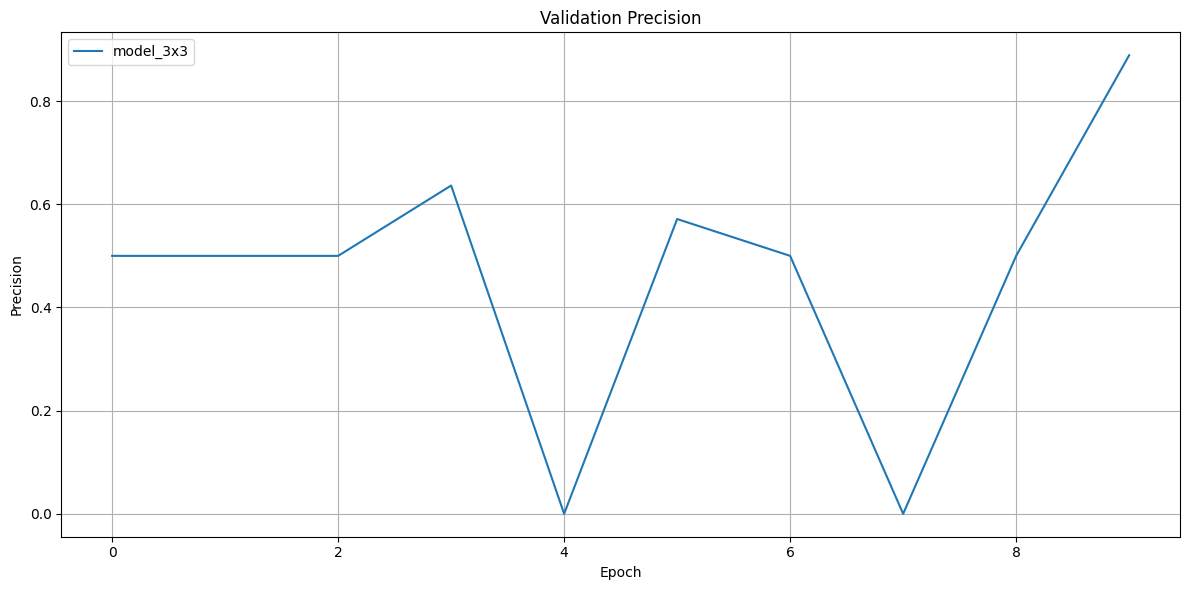

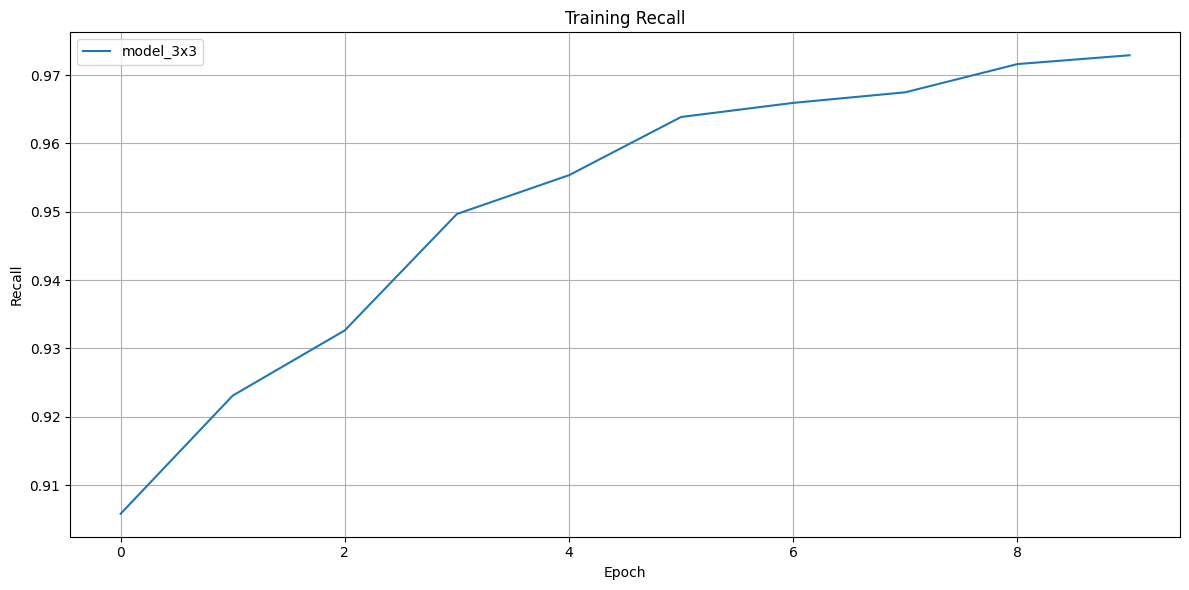

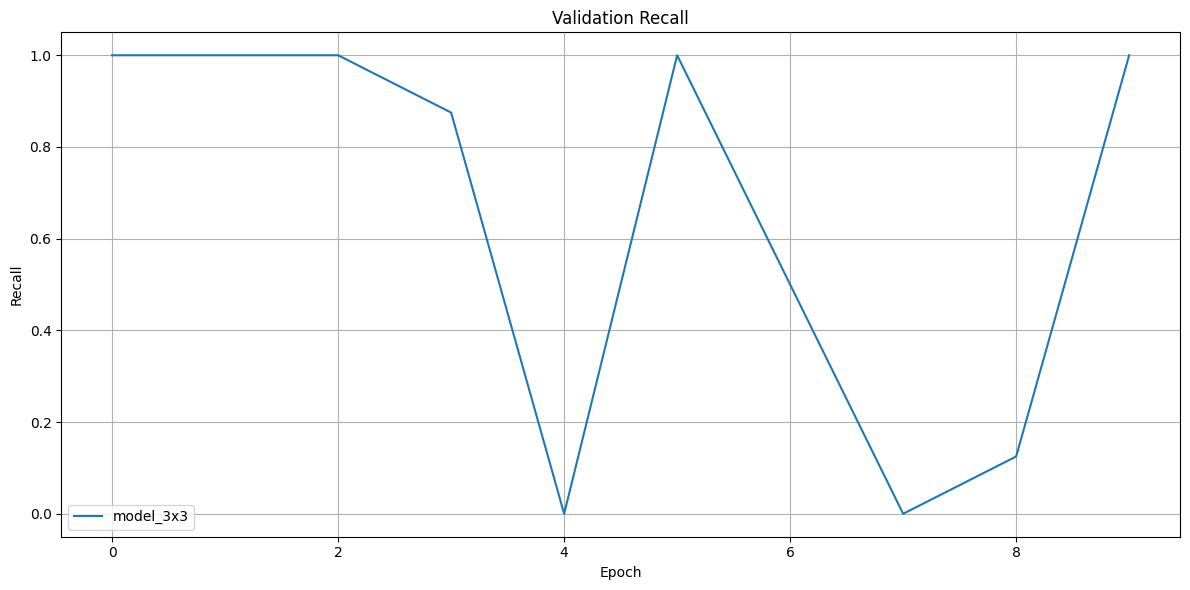

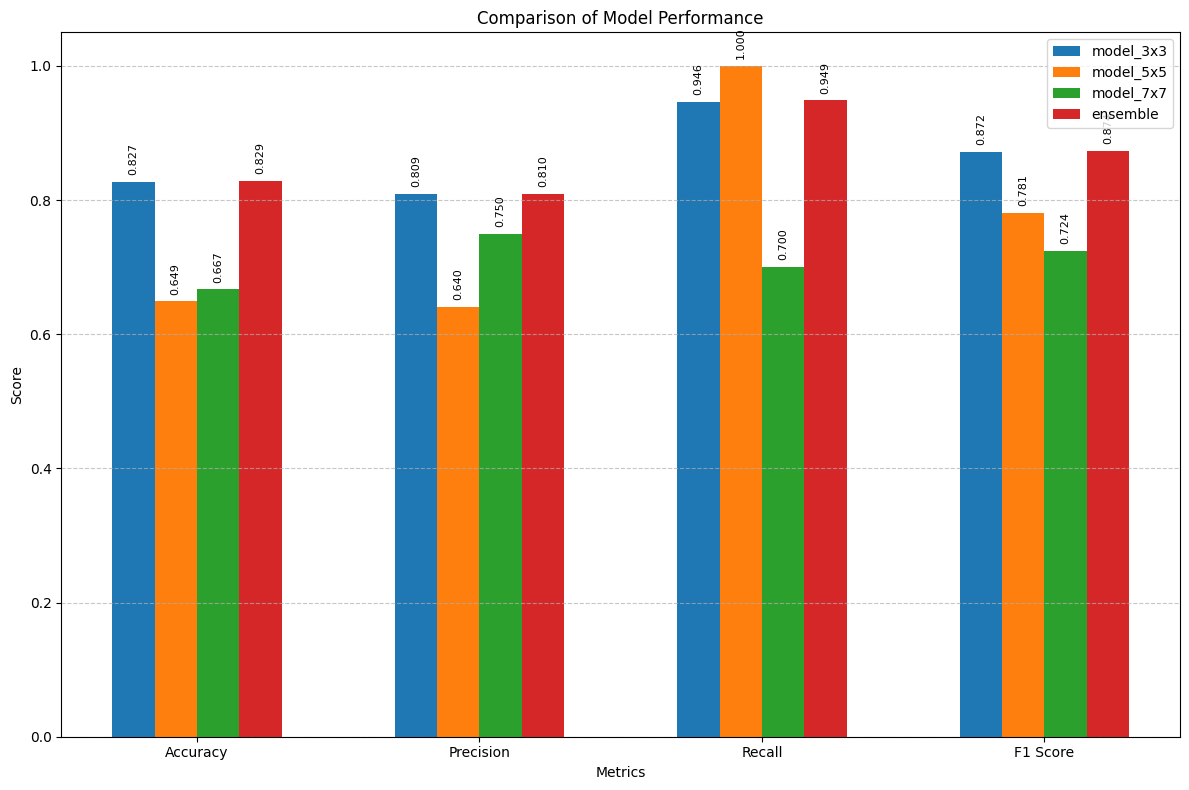


✅ All models trained and evaluated successfully!
✅ Results saved to '/kaggle/working/model_results.txt'
✅ Training history plot saved to '/kaggle/working/training_history.png'
✅ Model comparison plot saved to '/kaggle/working/model_comparison.png'


In [ ]:
# Main execution
# Train individual models
for kernel_name, kernel_size in kernel_sizes.items():
    train_model(kernel_name, kernel_size, epochs=10)

# Define weights for ensemble (can be adjusted based on individual model performance)
# Here we're weighting models by their validation F1 scores
ensemble_weights = {}
total_f1 = sum(metrics['val_f1'] for metrics in model_metrics.values())
for kernel_name, metrics in model_metrics.items():
    ensemble_weights[kernel_name] = metrics['val_f1'] / total_f1

print("\n=== Ensemble Weights ===")
for model_name, weight in ensemble_weights.items():
    print(f"{model_name}: {weight:.4f}")

# Find optimal threshold for ensemble
ensemble_threshold = find_optimal_ensemble_threshold(ensemble_weights)
print(f"\n🔍 Optimal threshold for ensemble model: {ensemble_threshold:.4f}")

# Evaluate ensemble model
ensemble_metrics = evaluate_ensemble(ensemble_weights, ensemble_threshold)

# Plot training history
plot_training_history()

# Plot comparative metrics
plot_comparative_metrics(ensemble_metrics)

# Save results to file
save_results(ensemble_threshold, ensemble_weights, ensemble_metrics)

print("\nAll models trained and evaluated successfully!")
print("Results saved to '/kaggle/working/model_results.txt'")
print("Training history plot saved to '/kaggle/working/training_history.png'")
print(" Model comparison plot saved to '/kaggle/working/model_comparison.png'")

## Zipping Project Files

This command compresses all the files and directories within the `/kaggle/working/` directory into a single zip file called `ann_project.zip`.

- `!zip`: Executes the `zip` command in the shell.
- `-r`: The `-r` flag enables recursive compression, meaning it includes all files and subdirectories within the specified directory.
- `/kaggle/working/ann_project.zip`: The destination path for the compressed zip file.
- `/kaggle/working/*`: Specifies that all files and subdirectories in the `/kaggle/working/` directory should be included in the zip file.

In [8]:
!zip -r /kaggle/working/ann_project.zip /kaggle/working/*

  adding: kaggle/working/cnn_attention_model_3x3.h5 (deflated 11%)
  adding: kaggle/working/cnn_attention_model_5x5.h5 (deflated 9%)
  adding: kaggle/working/cnn_attention_model_7x7.h5 (deflated 9%)
  adding: kaggle/working/cnn_attention_model.h5 (deflated 11%)
  adding: kaggle/working/model_comparison.png (deflated 21%)
  adding: kaggle/working/model_results.txt (deflated 56%)
  adding: kaggle/working/resnet_model.h5 (deflated 12%)
  adding: kaggle/working/training_accuracy.png (deflated 8%)
  adding: kaggle/working/training_loss.png (deflated 8%)
  adding: kaggle/working/training_precision.png (deflated 16%)
  adding: kaggle/working/training_recall.png (deflated 15%)
  adding: kaggle/working/validation_accuracy.png (deflated 7%)
  adding: kaggle/working/validation_loss.png (deflated 4%)
  adding: kaggle/working/validation_precision.png (deflated 9%)
  adding: kaggle/working/validation_recall.png (deflated 9%)


<h2 align="center">Thank you :)</h2>